In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')
from film import TwoMaterialFilm
from spectrum import Spectrum
from design import BaseDesign
import os

from analyze_utils.structure import plot_layer_thickness
from optimizer.adam import adam_optimize
import pickle



c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 34 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


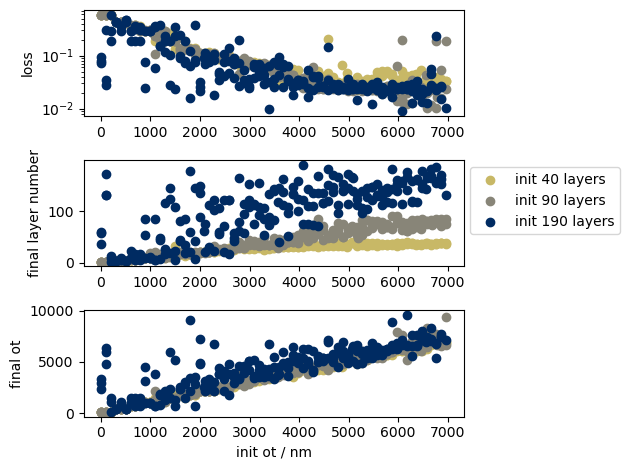

In [3]:


def load_designs(file_dir, filter=lambda x: True) -> list[Design]:
    fname_ls = os.listdir(file_dir)
    designs = []
    for fname in fname_ls:
        if not filter(fname):
            continue
        with open(file_dir + fname, 'rb') as f:
            designs.append(pickle.load(f))
    return designs




fig, (ax, ax2, ax3) = plt.subplots(3, 1)


for layer in [40, 90, 190]:

    losses = []
    init_ots = []
    final_layers = []
    final_ots = []

    dir = './raw_result/three_line_filter/SiO2_TiO2-400to700nm-700nm/'
    for design in load_designs(dir, lambda x: f'_layer{layer}_' in x):
        
        design.film.remove_negative_thickness_layer()
        final_layers.append(design.film.get_layer_number())
        losses.append(design.calculate_loss())
        init_ots.append(design.get_init_ot())
        final_ots.append(design.get_current_ot())

        
    color = cm.get_cmap('cividis')(1 - layer / 200)

    ax.scatter(init_ots, losses, label=f'init {layer} layers', color=color)
    ax2.scatter(init_ots, final_layers, label=f'init {layer} layers', color=color)
    ax3.scatter(init_ots, final_ots, label=f'init {layer} layers', color=color)


ax.set_ylabel('loss')
ax.set_yscale('log')

ax2.set_ylabel('final layer number')
ax2.legend(bbox_to_anchor=(1, 1))

ax3.set_xlabel('init ot / nm')
ax3.set_ylabel('final ot')
# ax3.legend()

fig.tight_layout()


init layer: 190
init ot: 4878.946741406426
loss: 0.023366384420483596


C:\Users\rfeng6\AppData\Roaming\Python\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


init layer: 190
init ot: 4877.407146530367
loss: 0.025607794577688952
init layer: 190
init ot: 4879.147153432392
loss: 0.023040438187120975


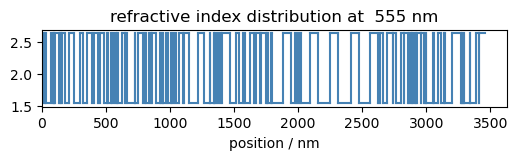

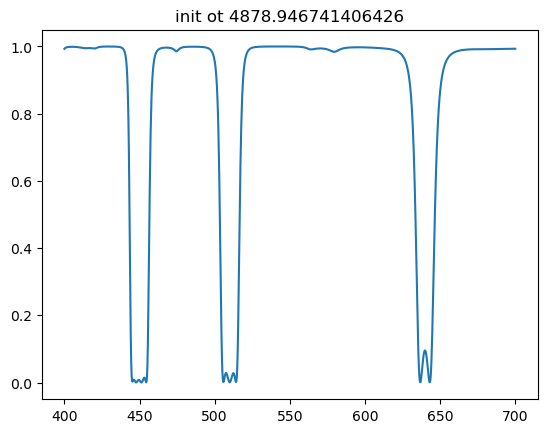

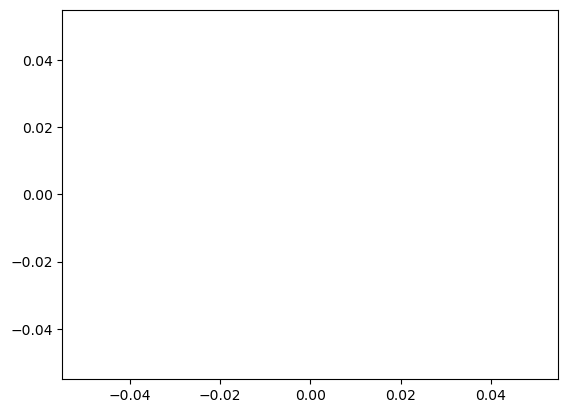

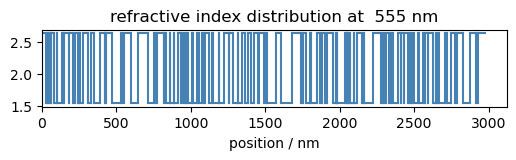

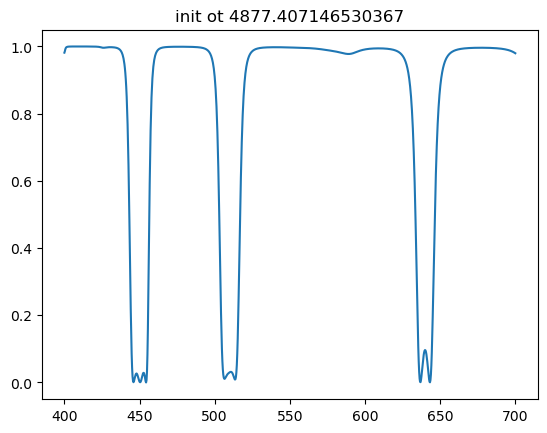

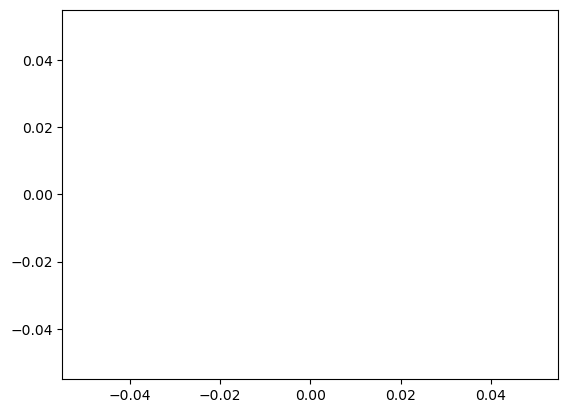

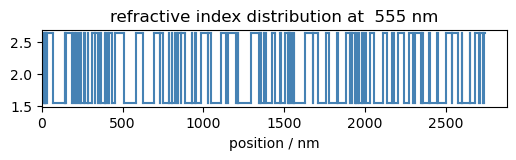

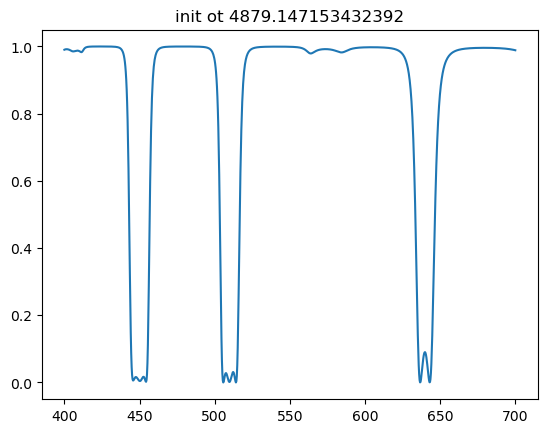

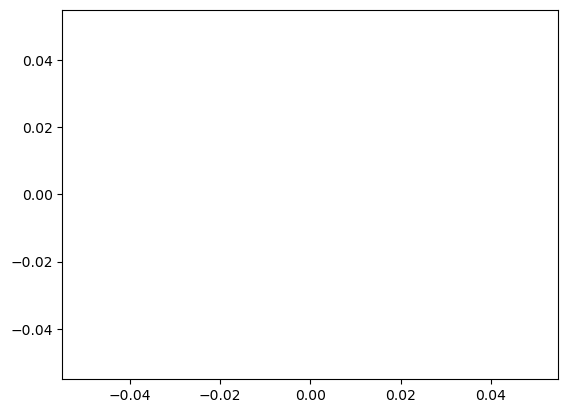

In [8]:
from analyze_utils.structure import plot_layer_thickness

def plot_deisgn(design):
    design.film.remove_negative_thickness_layer()
    print(f'init layer: {design.init_film.get_layer_number()}')
    print(f'init ot: {design.get_init_ot()}')
    print(f'loss: {design.calculate_loss()}')
    plot_layer_thickness(design.film)

dir = './raw_result/three_line_filter/SiO2_TiO2-400to700nm-700nm/'
layer = 190
import re
filter = lambda x: f'_layer{layer}_' in x and 5000 > float(re.match('ot(.*)_layer', x).group(1)) > 4900
designs = load_designs(dir, filter)

for design in designs:

    plot_deisgn(design)

    fig, ax = plt.subplots(1, 1)
    wls = np.linspace(400, 700, 1000)
    ax.plot(wls, design.film.get_spec(inc_ang=0., wls=wls).get_R())
    ax.set_title(f'init ot {design.get_init_ot()}')

    fig, ax = plt.subplots(1, 1)
    ax.plot([x['step'] for x in design.training_info], [x['loss'] for x in design.training_info])

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


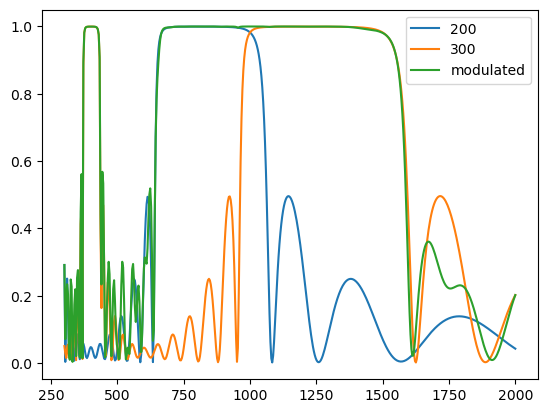

In [2]:

def make_bragg(d):
    modulated_bragg = TwoMaterialFilm('1', '2', 'SiO2', d, incidence='Air')
    modulated_bragg.add_spec_param(0., wls)
    return modulated_bragg

wls = np.linspace(300, 2000, 500)
layer = 7

fig, ax = plt.subplots(1, 1)
for l in [200, 300]:
    
    d = np.array([l, 0.5 * l] * layer)
    ax.plot(wls, make_bragg(d).get_spec().get_R(), label=f'{l}')

d = np.array([300, 0.5 * 300] * (layer // 1) + [200, 0.5 * 200] * layer)
ax.plot(wls, make_bragg(d).get_spec().get_R(), label='modulated')
ax.legend()

In [ ]:
from tmm.get_spectrum_angs import get_spectrum_simple as get_spectrum_angs_

def get_ang_spec(wl, angs, film: TwoMaterialFilm):
    spectrum = np.empty(angs.shape[0] * 2, dtype='float')
    same_wls = np.zeros(angs.shape[0]) + wl

    get_spectrum_angs_(
        spectrum, 
        wl, 
        film.get_d(), 
        film.calculate_n_array(same_wls), 
        film.calculate_n_sub(same_wls), 
        film.calculate_n_inc(same_wls), 
        angs
    )

    return spectrum[:angs.shape[0]]


def plot_band(film: TwoMaterialFilm):
    wl_min, wl_max = 400, 5000

    wls = np.linspace(1 / wl_max, 1 / wl_min, 500)
    wls = 1 / wls # even spacing w.r.t. freq.
    k = np.linspace(1 / wl_max, 1 / wl_min, 100)
    img = np.empty((wls.shape[0], k.shape[0]))

    for i, wl in enumerate(wls):
        
        img[i, :] = get_ang_spec(wl, np.arcsin(k * wl) * 180. / np.pi, film)

    fig, ax = plt.subplots(1, 1)
    s = ax.imshow(
        img, 
        extent=[1e9 * k[0], 1e9 * k[-1], 3e5 / wls[0], 3e5 / wls[-1]], 
        aspect='auto', 
        origin='lower', 
        vmin=0, 
        vmax=1, 
    )
    cbar = fig.colorbar(s)
    cbar.set_label('R')

    ax.set_xlabel('k_x / nm^{-1}')
    ax.set_ylabel('freq / THz')

    # ax.plot([k[0], k[-1]], [], label='n = 1')


def make_bragg(d):
    modulated_bragg = TwoMaterialFilm('TiO2', 'SiO2', '1', d, incidence='Air') # seems that the incident material needs to have lower n for band gap to open
    modulated_bragg.add_spec_param(0., wls)
    return modulated_bragg

d = np.array([100, 100] * 20)
plot_band(make_bragg(d))
    
        